# Character-Based Recurrent Neural Network

This notebook will build a character-based language model, using a recurrent neural network in PyTorch. This notebook should be accessible if you have tried a little [PyTorch](https://www.youtube.com/watch?v=v5cngxo4mIg&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG), and if you are familliar with classical feed forward neural networks.

This notebook will build up to the RNN model in a series of steps:

- Create a Dataset
- Define a generic training loop
- 1-character feed-forward network
- 2-character feed-forward network
- N-character feed-forward network
- Using Pytorch's RNN module
- Training more efficiently

This approach is heavily based on [lesson 6](https://course.fast.ai/lessons/lesson6.html) of FastAI [Deep Learning for Coders](https://course.fast.ai/). It's only indirectly related to Kapathy's [char-rnn](https://github.com/karpathy/char-rnn) implementation. 

In [1]:
# Imports and notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

# Create directory to store training data.
user_list = !whoami
username = user_list[0]
PATH = f'/home/{username}/data/char-rnn/'
os.makedirs(PATH, exist_ok=True)

In [2]:
# This notebook assumes that you have Nvidia CUDA available. If it is not, change all `.cuda()` calls to `.cpu()`
assert torch.cuda.is_available(), 'CUDA is not available.'
assert torch.backends.cudnn.enabled, 'CuDNN is not available.'

# Create a Dataset

Skip this if you don't care about PyTorch stuff, or where the data comes from.

We need to first get the training data. Below we create a subclass of `torch.Dataset`, which defines how to read the training data. I have not defined a test or validation dataset. In this particular case, `TextDataset` will download the full works of Nietzsche from S3 and load the text into memory for training.

In [3]:
import requests
import torch
from torch.utils.data import Dataset, DataLoader

SOURCE_URL = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt'
TARGET_FILE = f'{PATH}nietzsche.txt'

class TextDataset(Dataset):
    def __init__(self, num_chars):
        """
        Argument 'num_chars' determines how many characters are used to predict the next character.
        """
        self.num_chars = num_chars
        self.fetch_file()
        self.load_text()
    
    def fetch_file(self):
        """
        Fetch dataset file from SOURCE_URL if it doesn't exist locally.
        """
        if not os.path.exists(TARGET_FILE):
            print(f'Downloading from S3...', end=' ')
            response = requests.get(SOURCE_URL, stream=True)
            response.raise_for_status()
            with open(TARGET_FILE, 'wb') as f:
                for block in response.iter_content(1024):
                    f.write(block)

            print('done')
    
    def load_text(self):
        """
        Load the text from disk and convert characters to integers with a mapping.
        """
        with open(TARGET_FILE) as f:
            self.text = f.read()
        
        self.chars = sorted(list(set(self.text)))
        self.char_to_idx = {c: i for i, c in enumerate(self.chars)}
        self.idx_to_char = {i: c for i, c in enumerate(self.chars)}

    def __len__(self):
        """
        How many samples there are in the dataset.
        """
        return len(self.text) - self.num_chars - 1
    
    def __getitem__(self, idx):
        """
        Get item by integer index,
        returns (x_1, x_2, ..., x_n), y
        """
        inputs = torch.tensor([self.char_to_idx[c] for c in self.text[idx:idx + self.num_chars]])
        label = self.char_to_idx[self.text[idx + self.num_chars]]
        return inputs, label

In [4]:
# We can test out how the Dataset__getitem__ method works
train_ds = TextDataset(num_chars=3)
print('Source text:', repr(train_ds.text[:20]))
print('Int form:', [train_ds.char_to_idx[c] for c in train_ds.text[:20]])
for i in range(5):
    xs, y = train_ds[i]
    print('Sample', i, '- input', xs, 'label', y)

Source text: 'PREFACE\n\n\nSUPPOSING '
Int form: [39, 41, 28, 29, 24, 26, 28, 0, 0, 0, 42, 44, 39, 39, 38, 42, 32, 37, 30, 1]
Sample 0 - input tensor([39, 41, 28]) label 29
Sample 1 - input tensor([41, 28, 29]) label 24
Sample 2 - input tensor([28, 29, 24]) label 26
Sample 3 - input tensor([29, 24, 26]) label 28
Sample 4 - input tensor([24, 26, 28]) label 0


# Define a generic training loop

Skip this if you don't care how the models get trained.

Here we'll define a generic training loop which can be applied to all models. Below we define:

- `ProgressBar` - a helper class for printing stuff
- `train_net` - a training loop function that accepts a model and some hyperparameters as input


In [5]:
from tqdm import tqdm_notebook as tqdm

class ProgressBar():
    """
    Pretty progress bar for training - not super relevant.
    """
    def __init__(self, epoch, total_epochs, data_loader):
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.loss = 0
        self.progress = tqdm(
            iterable=iter(data_loader),
            leave=False,
            desc=f'epoch {epoch + 1} / {total_epochs}',
            total=len(data_loader),
            miniters=0
        )

    def update(self, loss):
        self.loss = loss
        self.progress.set_postfix(loss=loss, refresh=False)
        
    def __iter__(self):
        return self.progress.__iter__()
        
    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.progress.close()
        print(f'epoch {self.epoch + 1} / {self.total_epochs}, loss: {self.loss:0.4f}')


In [6]:
import torch.optim as optim

def train_net(net, data_set, num_epochs, **kwargs):
    """
    Train a model for some number of epochs.
        net         - a trainable model (torch.nn.Module)
        data_loader - training data (torch.utils.data.DataLoader) 
        num_epochs  - number of epochs to train for
    """
    # Get hyper-parameters, set defaults
    learning_rate = kwargs.get('learning_rate', 0.001)
    batch_size = kwargs.get('batch_size', 128)
    adam_betas = kwargs.get('adam_betas', (0.9, 0.999))
    
    # Use cross-entropy loss since we're doing multi-class classification
    criterion = kwargs.get('criterion', nn.CrossEntropyLoss())
    
    # Use Adam optimizer, because it's faster than classic gradient descent.
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=adam_betas)
    
    # Keep track of loss history
    loss_history = []
    loss_avg = 0
    loss_beta = 0.8
    
    # Create a DataLoader to iterate over the data set
    print('Creating data loader...', end=' ')
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=3)
    print('done')

    # Run training loop
    for epoch in range(num_epochs):
        with ProgressBar(epoch, num_epochs, data_loader) as progress:
            for inputs, labels in progress:
                # Tell PyTorch to reset gradient tracking.
                optimizer.zero_grad()
            
                # Get prediction from model
                outputs = net(inputs.cuda())
                                
                # Run loss function on over the model's prediction
                loss = criterion(outputs.cpu(), labels)
                
                # Calculate model weight gradients from the loss
                loss.backward()
                
                # Update model weights via gradient descent.
                optimizer.step()            
                
                # Log training information
                loss_amount = loss.data.item()
                loss_avg = loss_beta * loss_avg + (1 - loss_beta) * loss_amount
                progress.update(loss_avg)
                loss_history.append(loss_amount)
    
    # Plot training performance
    fig, ax = plt.subplots()
    ax.plot(loss_history)
    ax.set_title('Training performance')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')

## Define a 1-character feed-forward network

For starters we'll use a feed-forward neural network that:

- takes a single character index integer as an input
- transforms the character integer into an [embedding](https://github.com/MattSegal/fastai-notes/blob/master/theory/embeddings.md)
- runs the embedding activations through a hidden layer
- returns a softmax classification over all possible character classes


```

INPUT            EMBED          DENSE              SOFTMAX

char idx -->     embedding -->  linear + tanh -->  linear + softmax
                                                          |
                                                          v
                                                    output char idx predictions
```

I'm not sure _exactly_ why we're using `tanh` over `relu` here, but it's based on the fact that `tanh` produces a bounded output in \[-1, 1\], whereas `relu` can produce arbitrarily large values in \[0, inf\], which is bad because output values may get too large for repeated application of the same layer (future architectures). The choice doesn't seem to make much of a difference for the 1 and 2 character networks below.

In [8]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # Dense
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class OneCharNet(nn.Module):
    def __init__(self):
        super().__init__()        
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.dense = nn.Linear(*LAYERS[1])
        self.out = nn.Linear(*LAYERS[2])
        # Functions
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)
                             
    def forward(self, input_t):
        # Get embedding from character index
        embed_acts = self.embedding(input_t).squeeze(dim=1)

        # Pass embedding vector through a dense layer
        dense_acts = self.tanh(self.dense(embed_acts))
        
        # Make a prediction from output of dense layer
        prediction = self.softmax(self.out(dense_acts))
        return prediction

## Train the 1-character feed-forward network

Creating data loader... done


epoch 1 / 4, loss: 2.4909


epoch 2 / 4, loss: 2.4729


epoch 3 / 4, loss: 2.4888


epoch 4 / 4, loss: 2.4716


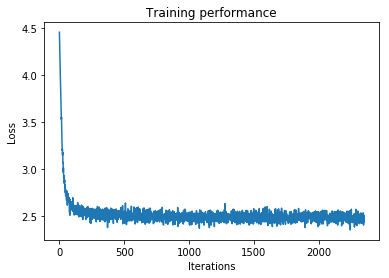

In [9]:
data_set = TextDataset(num_chars=1)
net = OneCharNet().cuda()
train_net(net, data_set, num_epochs=4, batch_size=1024)

## Test the 1-character feed-forward network

By _test_ I really mean _check_, or perhaps, _poke it with a stick_. Let's see what kind of text the model will produce from a seed example. You can see that the results suck, but they're not random noise.

In [10]:
import random

def generate_text(net, data_set, num_chars, length=100, seed='There will be many issues with', choices=3):
    """
    Use the provided `net` model to generate a sequence of characters, based on the seed.
    """
    text = seed
    for _ in range(length):
        input_text = text[-num_chars:]
        input_idxs = torch.tensor([data_set.char_to_idx[c] for c in input_text]).unsqueeze(dim=0).cuda()
        predictions = net(input_idxs).detach().squeeze().cpu().numpy()
        top_n_idxs = predictions.argsort()[-choices:]
        chosen_idx = random.choice(top_n_idxs)
        chosen_char = data_set.idx_to_char[chosen_idx.item()]
        text += chosen_char
    
    return text

In [11]:
generated_text = generate_text(net, data_set, 1, choices=1)
print(repr(generated_text))

'There will be many issues withe the the the the the the the the the the the the the the the the the the the the the the the the th'


In [12]:
generated_text = generate_text(net, data_set, 1, choices=2)
print(repr(generated_text))

'There will be many issues withan ander at at at the athand at andere t thathererer and t t t the an ander andere ather t thande t '


In [13]:
generated_text = generate_text(net, data_set, 1, choices=3)
print(repr(generated_text))

'There will be many issues withisen tofon at t tongen of athan t ondist athalitond to ofong ang therander ofonger ofenghisto at on '


## Define a 2-character feed-forward network

Lets add a 2nd character to the inputs. Now our network:

- takes two characters as an input
- transforms each character integer into an embedding
- runs the 1st char's embedding through a hidden layer
- runs the 2nd char's embedding, plus the 1st hidden layer through another hidden layer
- returns a softmax classification over all possible character classes


```

INPUT            EMBED          DENSE 1            DENSE 2           SOFTMAX

1st char idx --> embedding -->  linear + relu -->  linear + tanh
                                                      |
                                                      v
2nd char idx --> embedding -->  linear + relu -->  linear + tanh --> linear + softmax
                                                                          |
                                                                          v
                                                                     output char idx predictions
```

We can image that the:

- EMBED layer creaties a multi-dimensional representation for each character
- DENSE 1 layer selects important features from the character embeddings
- DENSE 2 layer produces a hidden state, which remembers past observations
- SOFTMAX chooses the next character, based on the hidden state

Looking at this diagram, a question arises: how do we add activations together when reading character 2? There are a few options. We could:

- Add the activations together elementwise
- Concatenate the activations into a new vector

In this case I will concatenate the activations, because using element addition will destroy information. This method seems to help improve the final training loss _a little bit_.

In [14]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # Dense 1
    (2*HIDDEN_PARAMS, HIDDEN_PARAMS),  # Dense 2
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class TwoCharNet(nn.Module):
    def __init__(self):
        super().__init__()        
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.dense_1 = nn.Linear(*LAYERS[1])
        self.dense_2 = nn.Linear(*LAYERS[2])
        self.out = nn.Linear(*LAYERS[3])
        # Functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)
                             
    def forward(self, input_t):
        # Get the embedding for each character
        embed_acts = self.embedding(input_t)
        
        # Run each character through the first dense layer
        dense_1_acts = self.relu(self.dense_1(embed_acts))

        # Initialize the second dense layer activations as all 0s
        batch_size = dense_1_acts.shape[0]
        dense_2_acts = torch.zeros(batch_size, HIDDEN_PARAMS).cuda()
        
        # Run first character activations through second dense layer. 
        char_1 = dense_1_acts[:, 0, :]
        dense_2_in = torch.cat((char_1, dense_2_acts), 1)
        dense_2_acts = self.tanh(self.dense_2(dense_2_in))

        # Run second character activations through second dense layer. 
        char_2 = dense_1_acts[:, 1, :]
        dense_2_in = torch.cat((char_2, dense_2_acts), 1)
        dense_2_acts = self.tanh(self.dense_2(dense_2_in))

        # Make a prediction over character classes given the final dense 2 activations
        prediction = self.softmax(self.out(dense_2_acts))
        return prediction

## Train the 2-character feed-forward network

You can see that using 2 characters instead of one slightly improves our final loss.

Creating data loader... done


epoch 1 / 4, loss: 2.0713


epoch 2 / 4, loss: 2.0382


epoch 3 / 4, loss: 2.0200


epoch 4 / 4, loss: 2.0220


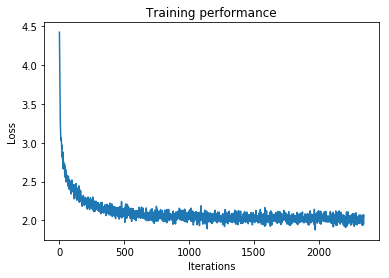

In [15]:
data_set = TextDataset(num_chars=2)
two_char_net = TwoCharNet().cuda()
train_net(two_char_net, data_set, num_epochs=4, batch_size=1024)

## Test the 2-character feed-forward network

It's... slightly better than before.

In [16]:
generated_text = generate_text(two_char_net, data_set, 2, choices=1)
print(generated_text)

There will be many issues withe the the the the the the the the the the the the the the the the the the the the the the the the th


In [17]:
generated_text = generate_text(two_char_net, data_set, 2, choices=2)
print(generated_text)

There will be many issues withistical to bectiould ast ist inge to
ding of
ally ander as as as thicall this and andes the on of as


In [18]:
generated_text = generate_text(two_char_net, data_set, 2, choices=3)
print(generated_text)

There will be many issues withiself--the sticis thas an of a sting the subly, the subje oftiorit in a the st it ithistanciat ing o


## Define an N-character feed-forward network

Lets modify our 2-character network to allow an arbitrary number of characters as inputs. Now our network will now look like this:

```

INPUT            EMBED          DENSE 1            DENSE 2           SOFTMAX

1st char idx --> embedding -->  linear + relu -->  linear + tanh
                                                      |
                                                      v
2nd char idx --> embedding -->  linear + relu -->  linear + tanh
                                                      |
                                                      v
                                                     ...
                                                      |
                                                      v
nth char idx --> embedding -->  linear + relu -->  linear + tanh --> linear + softmax
                                                                          |
                                                                          v
                                                                     output char idx predictions
```

In [18]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # Dense 1
    (2*HIDDEN_PARAMS, HIDDEN_PARAMS),  # Dense 2
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class NCharNet(nn.Module):
    def __init__(self):
        super().__init__()    
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.dense_1 = nn.Linear(*LAYERS[1])
        self.dense_2 = nn.Linear(*LAYERS[2])
        self.out = nn.Linear(*LAYERS[3])
        # Functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_t):
        # Get the embedding for each character
        embed_acts = self.embedding(input_t)
        
        # Run each character through the first dense layer
        dense_1_acts = self.relu(self.dense_1(embed_acts))
        batch_size, num_chars, num_hidden = dense_1_acts.shape
        
        # Initialize the second dense layer activations as all 0s
        dense_2_acts = torch.zeros(batch_size, num_hidden).cuda()

        # Run each character's activations through second dense layer. 
        for i in range(num_chars):
            char_acts = dense_1_acts[:, i, :]
            dense_2_in = torch.cat((char_acts, dense_2_acts), 1)
            dense_2_acts = self.tanh(self.dense_2(dense_2_in))

        # Make a prediction over character classes given the final dense 2 activations
        prediction = self.softmax(self.out(dense_2_acts))
        return prediction

## Train the N-character feed-forward network

You can see that using more characters continues to improve our final loss. We're also able to train out networks for longer. I also tweaked the batch size here to be smaller. This will take longer to compute, but will probably result in less redundant data per update and thus a better overall loss.

Creating data loader... done


epoch 1 / 8, loss: 1.7388


epoch 2 / 8, loss: 1.5791


epoch 3 / 8, loss: 1.5058


epoch 4 / 8, loss: 1.5018


epoch 5 / 8, loss: 1.4910


epoch 6 / 8, loss: 1.4661


epoch 7 / 8, loss: 1.4646


epoch 8 / 8, loss: 1.4087


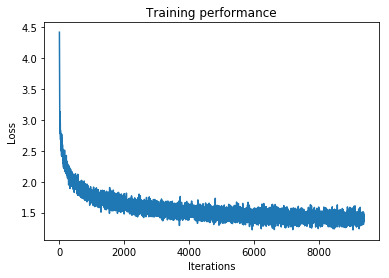

In [19]:
n = 12
data_set = TextDataset(num_chars=n)
n_char_net = NCharNet().cuda()
train_net(n_char_net, data_set, num_epochs=8, batch_size=512)

## Test the N-character feed-forward network

This is the best result so far. It's not _great_ but it's better than the 2-layer network.

In [20]:
generated_text = generate_text(n_char_net, data_set, n, choices=1)
print(generated_text)

There will be many issues with the same and the same and the same and the same and the same and the same and the same and the same


In [21]:
seed = 'Who is to say what the'
generated_text = generate_text(n_char_net, data_set, n, seed=seed, choices=2)
print(generated_text)

Who is to say what they art of
transity,
and therefort her should necate restine of this
concern an accumbedied than
and s


In [22]:
generated_text = generate_text(n_char_net, data_set, n, choices=2)
print(generated_text)

There will be many issues with
regarden as the same
that
to
bases,
and
truth,
to be anyty, to the sensible, an extranstenize a sen


In [23]:
generated_text = generate_text(n_char_net, data_set, n, choices=3)
print(generated_text)

There will be many issues with
races
and
evols is,"
anyth an arts, an eventure as it
make too seeptiours.
It
has the seline,"
its



## Using Pytorch's RNN module

You can use a PyTorch module to implement our N-character feed-forward network in fewer lines of code. PyTorch's [RNN class](https://pytorch.org/docs/stable/nn.html#torch.nn.RNN):

- does essentially the same thing as before
- has internal weights for both the input and hidden state
- does not apply a ReLU to the input like we did earlier
- does element-wise addition of input and hidden state by default (not concatenation)

The RNN `forward` function returns two values, which are explained [here](https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm).

As you can see below, this implementation achieves a similar loss on the training set to `NCharNet`.

In [24]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # RNN
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class NCharNetSimplified(nn.Module):
    def __init__(self):
        super().__init__()    
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.rnn = nn.RNN(*LAYERS[1], batch_first=True)
        self.out = nn.Linear(*LAYERS[2])
        # Functions
        self.softmax = nn.LogSoftmax(dim=1)
            
    def forward(self, input_t):
        # Get the embedding for each character
        embed_acts = self.embedding(input_t)
        batch_size = embed_acts.shape[0]
        
        # Initialize the RNN hidden state activations as all 0s
        hidden_acts = torch.zeros(1, batch_size, HIDDEN_PARAMS).cuda()

        # Run each character's activations through the RNN in sequence.
        rnn_history_acts, _ = self.rnn(embed_acts, hidden_acts)
        rnn_final_acts = rnn_history_acts[:, -1, :].squeeze(dim=1)

        # Make a prediction over character classes given the final dense 2 activations
        prediction = self.softmax(self.out(rnn_final_acts))
        return prediction

Creating data loader... done


epoch 1 / 4, loss: 1.8067


epoch 2 / 4, loss: 1.6641


epoch 3 / 4, loss: 1.5884


epoch 4 / 4, loss: 1.5449


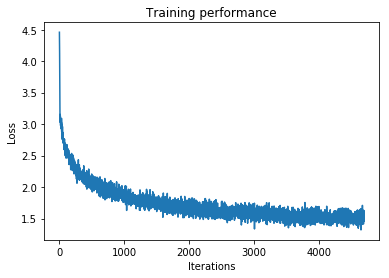

In [25]:
# Train NCharNetSimplified for a few epochs.
n = 12
data_set = TextDataset(num_chars=n)
n_char_net = NCharNetSimplified().cuda()
train_net(n_char_net, data_set, num_epochs=4, batch_size=512)

In [26]:
# Check the model output.
generated_text = generate_text(n_char_net, data_set, n, choices=1)
print(generated_text)

There will be many issues with the same that the same that the same that the same that the same that the same that the same that t


# Training more efficiently

Skip this section if you don't care about training more efficiently.

One feature of PyTorch's RNN module is that it doesn't just output the last hidden activation of a sequence, it instead outputs a list of predicted activations. That is:

```
IN      CHAR     EMBED       HIDDEN      PREDICT

H  -->  1    --> [.2,.3] --> [.9,.1]  
e  -->  42   --> [.4,.1] --> [.8,.2] --> e
l  -->  32   --> [.2,.3] --> [.7,.3] --> l
l  -->  11   --> [.2,.5] --> [.6,.4] --> l
o  -->  9    --> [.5,.3] --> [.5,.5] --> o
   -->  53   --> [.7,.3] --> [.4,.6] --> 
W  -->  52   --> [.4,.1] --> [.3,.7] --> W
o  -->  78   --> [.2,.3] --> [.2,.8] --> o
r  -->  92   --> [.3,.2] --> [.1,.9] --> r
l  -->  31   --> [.1,.7] --> [.1,.1] --> l
                             [.1,.2] --> d
                             
```

We can leverage feature this to train our model more efficiently. Note that I skipped over the softmax step in the above diagram for simplcity. 

### The problem

Currently for the sentence "Hello World!", and a 5 character window, we would do the following training steps:

```
Hello World! How are you?

Hello[ ]
 ello [W]
  llo W[o]
   lo Wo[r]
    o Wor[l]
      Worl[d]
      World[!]
       ... etc
```

That will be 20 training steps for 25 characters (25 - 5), and this will grow linearly in the number of characters in our  training data: For N characters we will do `N - 5` training steps per epoch.

### An improvement

We can split our training data into non-overlapping segment as follows:

```
Hello World! How are you?

INPUT       PREDICTION

'Hello' --> 'ello '
' Worl' --> 'World'
'd! Ho' --> '! How'
'w are' --> ' are '
' you?' --> 'you? '
```

This is 5 training steps for 25 characters (25 / 5). For N characters we will do `N / 5` traning steps per epoch.

### Implementation

We will need to:

- Update our Dataset to return data in segments
- Update our model to return all RNN outputs
- Define a new loss function to handle the output vectors

In [59]:
# Updating our Dataset
class SegmentedTextDataset(TextDataset):
    def __len__(self):
        """
        How many samples there are in the dataset.
        """
        return len(self.text) // self.num_chars

    def __getitem__(self, idx):
        """
        Get item by integer index,
        returns (x_1, x_2, ..., x_n), (x_2, x_3, ..., x_n+1)
        """
        inputs = torch.tensor([self.char_to_idx[c] for c in self.text[idx:idx + self.num_chars]])
        label = torch.tensor([self.char_to_idx[c] for c in self.text[idx + 1:idx + 1 + self.num_chars]])
        return inputs, label

In [60]:
# Updating our model
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # RNN
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class NCharNetSegmented(nn.Module):
    def __init__(self):
        super().__init__()    
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.rnn = nn.RNN(*LAYERS[1], batch_first=True)
        self.out = nn.Linear(*LAYERS[2])
        # Functions
        self.softmax = nn.LogSoftmax(dim=1)
            
    def forward(self, input_t):
        # Get the embedding for each character
        embed_acts = self.embedding(input_t)
        batch_size = embed_acts.shape[0]
        
        # Initialize the RNN hidden state activations as all 0s
        hidden_acts = torch.zeros(1, batch_size, HIDDEN_PARAMS).cuda()

        # Run each character's activations through the RNN in sequence.
        rnn_acts, _ = self.rnn(embed_acts, hidden_acts)

        # Make a prediction over character classes given the final dense 2 activations
        prediction = self.softmax(self.out(rnn_acts))
        return prediction

In [67]:
# Create custom loss function
class CrossEntropySequential:
    def __init__(self):
        self.ce =  nn.CrossEntropyLoss()

    def __call__(self, inputs, target):
        """
        Reshape targets and inputs before passing to the loss function.
        
        inputs: batch x seq x vocab => batch*seq x vocab
        target: batch x seq         => batch*seq
                """
        batch_size, sequence_length, vocab = inputs.shape
        reshaped_inputs = inputs.view(-1, vocab)
        reshaped_target = target.transpose(0, 1).contiguous().view(-1)        
        return self.ce(reshaped_inputs, reshaped_target)

Creating data loader... done


epoch 1 / 20, loss: 3.5915


epoch 2 / 20, loss: 3.2804


epoch 3 / 20, loss: 3.2784


epoch 4 / 20, loss: 3.2685


epoch 5 / 20, loss: 3.2615


epoch 6 / 20, loss: 3.2757


epoch 7 / 20, loss: 3.2460


epoch 8 / 20, loss: 3.2660


epoch 9 / 20, loss: 3.2515


epoch 10 / 20, loss: 3.2605


epoch 11 / 20, loss: 3.2533


epoch 12 / 20, loss: 3.2600


epoch 13 / 20, loss: 3.2548


epoch 14 / 20, loss: 3.2687


epoch 15 / 20, loss: 3.2672


epoch 16 / 20, loss: 3.2590


epoch 17 / 20, loss: 3.2586


epoch 18 / 20, loss: 3.2526


epoch 19 / 20, loss: 3.2657


epoch 20 / 20, loss: 3.2610


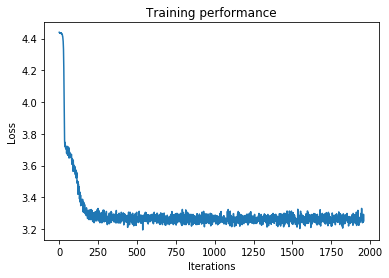

In [69]:
# Train NCharNetSegmented for a few epochs. (prev 110 iters / second, now )
n = 12
data_set = SegmentedTextDataset(num_chars=n)
inputs, labels = data_set[0]
criterion = CrossEntropySequential()
n_char_segmented_net = NCharNetSegmented().cuda()
train_net(n_char_segmented_net, data_set, num_epochs=20, batch_size=512, criterion=criterion)

# It's terrible!

Who said this was a good idea!?